In [1]:
from rtree import index
from copy import copy
import os
import xml.etree.ElementTree as ET
from copy import copy
from scipy import spatial
import numpy as np
import libtiff
from scipy import ndimage as nd
from matplotlib import pyplot as plt
import networkx as nx
import community
%matplotlib inline
import gc

In [129]:
Prox = {}

def spherical_trsf(pos):
    x, y, z = pos
    r = (x**2 + y**2 + z**2)**.5
    teta = np.arccos(z/r)
    phi = np.arctan2(x, y)
    return r, teta, phi

center_position = {
    0: (400*4, 223*4, 129*4),
    50: (378*4, 239*4, 131*4),
    100: (406*4, 217*4, 129*4),
    150: (394*4, 236*4, 126*4),
    200: (377*4, 239*4, 131*4)
}

from matplotlib import cm
mean_center = np.mean(center_position.values(), axis=0)
mean_center[1] = 1100.

class CellSS(object):
    """docstring for CellSS:
        self.unique_id: id that is unique to the graph it is contained in
        self.id: id from the input data
        self.M: Mother of the """
    def __init__(self, unique_id, id, M, time, pos, D=None, N=None):
        self.unique_id = unique_id
        self.id = id
        self.time = time
        self.M = M
        if D is None:
            self.D = []
        else:
            self.D = D
        if N is None:
            self.N = []
        else:
            self.N = N
        self.pos = np.array(pos)

class LineageTree(object):
    """docstring for LineageTree"""


    def _dist_v(self, v1, v2):
        v1 = np.array(v1)
        v2 = np.array(v2)
        return np.sum((v1-v2)**2)**(.5)

    def copy_cell(self, C, links=[]):
        C_tmp = copy(C)
        self.nodes.append(C)


    def to_tlp(self, fname, t_min=-1, t_max=np.inf, temporal=True, spatial=False, VF=False):
        """
        Write a lineage tree into an understable tulip file
        fname : path to the tulip file to create
        lin_tree : lineage tree to write
        properties : dictionary of properties { 'Property name': [{c_id: prop_val}, default_val]}
        """
        
        f=open(fname, "w")

        f.write("(tlp \"2.0\"\n")
        f.write("(nodes ")
        if t_max!=np.inf or t_min>-1:
            nodes_to_use = [n for n in self.nodes if t_min<n.time<=t_max]
            edges_to_use = []
            if temporal:
                edges_to_use += [e for e in self.edges if t_min<e[0].time<t_max]
            if spatial:
                edges_to_use += [e for e in self.spatial_edges if t_min<e[0].time<t_max]
        else:
            nodes_to_use = self.nodes
            edges_to_use = []
            if temporal:
                edges_to_use += self.edges
            if spatial:
                edges_to_use += self.spatial_edges

        for n in nodes_to_use:
            f.write(str(n.unique_id)+ " ")
        f.write(")\n")

        for i, e in enumerate(edges_to_use):
            f.write("(edge " + str(i) + " " + str(e[0].unique_id) + " " + str(e[1].unique_id) + ")\n")
        f.write("(property 0 int \"id\"\n")
        f.write("\t(default \"0\" \"0\")\n")
        for n in nodes_to_use:
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.id) + "\")\n")
        f.write(")\n")

        f.write("(property 0 int \"time\"\n")
        f.write("\t(default \"0\" \"0\")\n")
        for n in nodes_to_use:
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.time) + "\")\n")
        f.write(")\n")

        f.write("(property 0 layout \"viewLayout\"\n")
        f.write("\t(default \"(0, 0, 0)\" \"()\")\n")
        for n in nodes_to_use:
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(tuple(n.pos)) + "\")\n")
        f.write(")\n")

        f.write("(property 0 double \"distance\"\n")
        f.write("\t(default \"0\" \"0\")\n")
        for i, e in enumerate(edges_to_use):
            d_tmp = self._dist_v(e[0].pos, e[1].pos)
            f.write("\t(edge " + str(i) + str(" \"") + str(d_tmp) + "\")\n")
            f.write("\t(node " + str(e[0].unique_id) + str(" \"") + str(d_tmp) + "\")\n")
        f.write(")\n")

        # for property in properties:
        #     prop_name=property[0]
        #     vals=property[1]
        #     default=property[2]
        #     f.write("(property 0 string \""+prop_name+"\"\n")
        #     f.write("\t(default \""+str(default)+"\" \"0\")\n")
        #     for node in nodes:
        #         f.write("\t(node " + str(node) + str(" \"") + str(vals.get(node, default)) + "\")\n")
        #     f.write(")\n") 
        f.write(")")
        f.close()

    def median_average(self, subset):
        subset_dist = [np.mean([di.pos for di in c.D], axis = 0) - c.pos for c in subset if c.D != []]
        target_C = [c for c in subset if c.D != []]
        if subset_dist != []:
            med_distance = spatial.distance.squareform(spatial.distance.pdist(subset_dist))
            return subset_dist[np.argmin(np.sum(med_distance, axis=0))]
        else:
            return [0, 0, 0]

    def median_average_bw(self, subset):
        subset_dist = [c.M.pos - c.pos for c in subset if c.M != self.R]
        target_C = [c for c in subset if c.D != []]
        if subset_dist != []:
            med_distance = spatial.distance.squareform(spatial.distance.pdist(subset_dist))
            return subset_dist[np.argmin(np.sum(med_distance, axis=0))]
        else:
            return [0, 0, 0]

    def build_median_vector(self, C, dist_th, delta_t = 2):#temporal_space=lambda d, t, c: d+(t*c)):
        if not hasattr(self, 'spatial_edges'):
            self.compute_spatial_edges(dist_th)
        subset = [C]
        subset += C.N
        added_D = added_M = subset
        for i in xrange(delta_t):
            _added_D = []
            _added_M = []
            for c in added_D:
                _added_D += c.D
            for c in added_M:
                if not c.M is None:
                    _added_M += [c.M]
            subset += _added_M
            subset += _added_D
            added_D = _added_D
            added_M = _added_M


        return self.median_average(subset)

    def build_vector_field(self, dist_th=50):
        ruler = 0
        for C in self.nodes:
            if ruler != C.time:
                print C.time
            C.direction = self.build_median_vector(C, dist_th)
            ruler = C.time

    def read_from_xml(self, file_format, tb, te, z_mult=1.):
        self.time = {}
        self.time_edges = {}
        unique_id = 0
        self.R = CellSS(-1, -1, None, -1, [-1]*3)
        self.nodes = []
        self.edges = []
        for t in range(tb, te+1):
            t_str = '%04d' % t
            tree = ET.parse(file_format.replace('$TIME$', t_str))
            root = tree.getroot()
            self.time[t] = {}
            self.time_edges[t] = []
            for it in root.getchildren():
                M_id, pos, cell_id = (int(it.attrib['parent']), 
                                      [float(v) for v in it.attrib['m'].split(' ') if v!=''], 
                                      int(it.attrib['id']))
                pos[-1] = pos[-1]*z_mult
                if self.time.get(t-1, {}).has_key(M_id):
                    M = self.time[t-1][M_id]
                    C = CellSS(unique_id, cell_id, M, t, pos)
                    M.D.append(C)
                    self.edges.append((M, C))
                    self.time_edges[t].append((M, C))
                else:
                    C = CellSS(unique_id, cell_id, self.R, t, pos)
                    self.R.D.append(C)

                self.nodes.append(C)
                self.time[t][cell_id] = C
                unique_id += 1
        self.max_id = unique_id - 1

    def build_VF_propagation(self, t_b=0, t_e=200, nb_max=20, dist_max=200):
        VF = LineageTree(None, None, None)
        VF.nodes = []
        VF.edges = []
        VF.R = CellSS(-1, -1, None, -1, None)
        starting_cells = self.time[t_b].values()
        unique_id = 0
        VF.time = {t_b: []}
        for i, C in enumerate(starting_cells):
            C_tmp = CellSS(unique_id=unique_id, id=unique_id, M=VF.R, time = t_b, pos = C.pos)
            VF.nodes.append(C_tmp)
            VF.time[t_b].append(C_tmp)
            unique_id+=1

        for t in range(t_b, t_e):
            p = index.Property()
            p.dimension = 3
            idx3d = index.Index(properties=p)
            to_check_self = self.time[t].values()
            to_check_VF = VF.time[t]
            for i, C in enumerate(to_check_self):
                idx3d.add(i, tuple(C.pos))
            print t
            VF.time[t+1] = []
            for C in to_check_VF:
                closest_cells = np.array(to_check_self)[list(idx3d.nearest(tuple(C.pos), nb_max))]
                max_value = np.min(np.where(np.array([self._dist_v(C.pos, ci.pos) for ci in closest_cells]+[dist_max+1])>dist_max))
                cells_to_keep = closest_cells[:max_value]
                med = self.median_average(cells_to_keep)
                C_next = CellSS(unique_id, unique_id, M=C, time = t+1, pos= C.pos + med)
                VF.time[t+1].append(C_next)
                C.D.append(C_next)
                # C.d_p = med
                VF.edges.append((C, C_next))
                VF.nodes.append(C_next)
                unique_id += 1
        VF.t_b = t_b
        VF.t_e = t_e
        return VF



    def build_VF_propagation_backward(self, t_b=0, t_e=200, nb_max=20, dist_max=200):
        VF = LineageTree(None, None, None)
        VF.nodes = []
        VF.edges = []
        VF.R = CellSS(-1, -1, None, -1, None)
        starting_cells = self.time[t_b].values()
        unique_id = 0
        VF.time = {t_b: []}
        for i, C in enumerate(starting_cells):
            C_tmp = CellSS(unique_id=unique_id, id=unique_id, M=VF.R, time = t_b, pos = C.pos)
            VF.nodes.append(C_tmp)
            VF.time[t_b].append(C_tmp)
            unique_id+=1

        if t_b>t_e : 
            increment = -1
        else: 
            increment = 1
        for t in range(t_b, t_e, -1):
            p = index.Property()
            p.dimension = 3
            idx3d = index.Index(properties=p)
            to_check_self = self.time[t].values()
            to_check_VF = VF.time[t]
            for i, C in enumerate(to_check_self):
                idx3d.add(i, tuple(C.pos))
            print t
            VF.time[t-1] = []
            for C in to_check_VF:
                closest_cells = np.array(to_check_self)[list(idx3d.nearest(tuple(C.pos), nb_max))]
                max_value = np.min(np.where(np.array([self._dist_v(C.pos, ci.pos) for ci in closest_cells]+[dist_max+1])>dist_max))
                cells_to_keep = closest_cells[:max_value]
                med = self.median_average_bw(cells_to_keep)
                C_next = CellSS(unique_id, unique_id, M=C, time = t-1, pos= C.pos + med)
                VF.time[t-1].append(C_next)
                C.D.append(C_next)
                # C.d_p = med
                VF.edges.append((C, C_next))
                VF.nodes.append(C_next)
                unique_id += 1
        VF.t_b = t_b
        VF.t_e = t_e
        return VF

    def compute_spatial_edges(self, th=50):
        self.spatial_edges=[]
        for t, Cs in self.time.iteritems():
            nodes_tmp, pos_tmp = zip(*[(C, C.pos) for C in Cs.itervalues()])
            nodes_tmp = np.array(nodes_tmp)
            distances = spatial.distance.squareform(spatial.distance.pdist(pos_tmp))
            nodes_to_match = np.where((0<distances) & (distances<th))
            to_link = zip(nodes_tmp[nodes_to_match[0]], nodes_tmp[nodes_to_match[1]])
            self.spatial_edges.extend(to_link)
            for C1, C2 in to_link:
                C1.N.append(C2)

    def __init__(self, file_format, tb, te, z_mult = .1):
        super(LineageTree, self).__init__()
        
        if not (file_format is None or tb is None or te is None):
            self.read_from_xml(file_format, tb, te, z_mult=z_mult)
            self.t_b = tb
            self.t_e = te


def reduce_graph(VF, t_b=None, t_e=None, reduction_scale=5):
    # import cPickle as pkl
    # f = open(p_to_VF)
    # VF = pkl.load(f)
    # f.close()
    if t_b is None:
        t_b = VF.t_b
    if t_e is None:
        t_e = VF.t_e

    VF_reduced = LineageTree(None, None, None)
    VF_reduced.nodes = []
    VF_reduced.edges = []
    VF_reduced.R = CellSS(-1, -1, None, -1, None)
    starting_cells = VF.time[t_b]
    unique_id = 0
    VF_reduced.time = {t_b: []}
    for i, C in enumerate(starting_cells):
        C_tmp = CellSS(unique_id=unique_id, id=unique_id, M=VF_reduced.R, D=copy(C.D), time = t_b, pos = C.pos)
        VF_reduced.nodes.append(C_tmp)
        VF_reduced.time[t_b].append(C_tmp)
        unique_id+=1

    for t in xrange(t_b, t_e, reduction_scale):
        VF_reduced.time[t+reduction_scale] = []
        for C in VF_reduced.time[t]:
            C_tmp = copy(C)
            for i in range(np.abs(reduction_scale)):
                if len(C_tmp.D)!=0:
                    C_tmp = copy(C_tmp.D[0])
            C_to_add = CellSS(unique_id, unique_id, M=C, D=C_tmp.D, time = t+reduction_scale, pos = C_tmp.pos)
            VF_reduced.time[t+reduction_scale].append(C_to_add)
            C.D = [C_to_add]
            VF_reduced.edges.append((C, C_to_add))
            VF_reduced.nodes.append(C_to_add)
            unique_id += 1
    return VF_reduced

def dist_v(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1-v2)**2)**(.5)

def conn_G_to_tlp(fname, b_g):

    nodes_to_use = b_g.keys()
    tmp_edges = [(k, vi) for k, v in b_g.iteritems() for vi in v]

    f=open(fname, "w")

    f.write("(tlp \"2.0\"\n")

    f.write("(nodes ")
    for n in nodes_to_use:
        f.write(str(n.unique_id)+ " ")
    f.write(")\n")

    for i, e in enumerate(tmp_edges):
        f.write("(edge " + str(i) + " " + str(e[0].unique_id) + " " + str(e[1].unique_id) + ")\n")
    
    f.write("(property 0 int \"id\"\n")
    f.write("\t(default \"0\" \"0\")\n")
    for n in nodes_to_use:
        f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.id) + "\")\n")
    f.write(")\n")

    # f.write("(property 0 int \"time\"\n")
    # f.write("\t(default \"0\" \"0\")\n")
    # for n in nodes_to_use:
    #     f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.time) + "\")\n")
    # f.write(")\n")

    f.write("(property 0 layout \"viewLayout\"\n")
    f.write("\t(default \"(0, 0, 0)\" \"()\")\n")
    for n in nodes_to_use:
        f.write("\t(node " + str(n.unique_id) + str(" \"") + str(tuple(n.pos)) + "\")\n")
    f.write(")\n")

    f.write("(property 0 double \"distance\"\n")
    f.write("\t(default \"0\" \"0\")\n")
    for i, e in enumerate(tmp_edges):
        f.write("\t(edge " + str(i) + str(" \"") + str(dist_v(e[0].pos, e[1].pos)) + "\")\n")    
    f.write(")\n")

    f.write("(property 0 int \"P\"\n")
    f.write("\t(default \"0\" \"0\")\n")
    for n in nodes_to_use:
        if hasattr(n, 'P'):
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.P) + "\")\n")
    f.write(")\n")

    f.write(")")
    f.close()

In [4]:
path_to_files = 'D:\Users\Leo\X_SiMView1_14-05-21XML_finalResult_lht_bckgRm'
# 'D:\Users\Leo\FernandoTGMMRuns\GMEMtracking3D_2015_3_6_17_42_12_Drosophila_12_08_28_trainCDWT_iter5\XML_finalResult_lht'
LT = LineageTree(file_format = path_to_files + '\GMEMfinalResult_frame$TIME$.xml', tb = 0, te = 200, z_mult = 5.)

C:\Users\Leo\Anaconda2\lib\site-packages\ipykernel\__main__.py:188: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


In [5]:
VF = LT.build_VF_propagation_backward(t_b = 200, t_e = 0, nb_max = 50)

200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [6]:
VF_R = reduce_graph(VF, reduction_scale=-5)
VF_R.to_tlp('VF_R_bw.tlp')

VF_R_tmp = copy(VF_R)
Neighbs = {}
max_N = 20
dist_max = 80
for t, Cs in VF_R_tmp.time.iteritems():
    print t
    p = index.Property()
    p.dimension = 3
    idx3d = index.Index(properties=p)
    if not Prox.has_key(t):
        for i, C in enumerate(Cs):
            idx3d.add(i, tuple(C.pos))
        Prox[t] = idx3d
    else:
        idx3d = Prox[t]
    for i, C in enumerate(Cs):
        closest_cells = np.array(Cs)[list(idx3d.nearest(tuple(C.pos), max_N))]
        max_value = np.min(np.where(np.array([VF_R_tmp._dist_v(C.pos, ci.pos) for ci in closest_cells]+[dist_max+1])>dist_max))
        to_add = list(closest_cells[1:max_value])
        C.N = to_add
        for Cn in list(closest_cells[1:max_value]):
            VF_R_tmp.edges.append((C, Cn))


built_graph = {}
t= 200
for C_tb in VF_R_tmp.time[t]:
    N_tb = C_tb.N
    N_tmp = C_tb.N
    while N_tmp != []:
        N_te = N_tmp
        N_tmp = [n for N in N_tmp for n in N.D]
    C_te = C_tb
    while C_te.D != []:
        C_te = C_te.D[0]
    built_graph[C_te] = list(set(C_te.N).intersection(N_te))

0
130
5
135
10
140
15
145
20
150
25
155
30
160
35
165
40
170
45
175
50
180
55
185
60
190
65
195
70
200
75
80
85
90
95
100
105
110
115
120
125


In [7]:
VF_R = VF_R_tmp

corres_table = {c.unique_id: c for c in built_graph.keys()}

G = nx.Graph()

for k, v in built_graph.iteritems():
    for vi in v:
        G.add_edge(k.unique_id, vi.unique_id)

partition = community.best_partition(G)

for id_, p in partition.iteritems():
    corres_table[id_].P = p

for id_, P in partition.iteritems():
    C_next = corres_table[id_]
    while C_next != VF_R.R:
        C_next.P = P
        C_next = C_next.M

conn_G_to_tlp('connexity_bw.tlp', built_graph)
VF_R.to_tlp(path_to_files + '\VF_R_bw.tlp')

In [63]:
from sklearn.decomposition import PCA
from scipy.ndimage import filters as filters

cc = list(nx.connected_components(G))
to_keep = cc[np.argmax([len(c) for c in cc])]
Cells = []
dteta_in_time = []
dphi_in_time = []
dr_in_time = []
corres_cell_dist_mat = {}
i = 0
for C in VF_R.time[0]:
    if 600<C.pos[1] and C.unique_id in to_keep:
        Cells += [C]
        corres_cell_dist_mat[C.unique_id] = i
        i += 1
#         positions = [C.pos]
        positions_sphere = [spherical_trsf(C.pos - mean_center)]
        actual = C.M
        for t in range(5, 201, 5):
#             positions += [actual.pos]
            positions_sphere += [spherical_trsf(actual.pos - mean_center)]
            if actual.M != VF_R.R:
                actual = actual.M
        positions_sphere = np.array(positions_sphere)
#         r_smoothed = filters.median_filter(positions_sphere[:,0])
#         teta_smoothed = filters.median_filter(positions_sphere[:,1], 2)
        teta_smoothed = positions_sphere[:,1]
        phi_smoothed = positions_sphere[:,2]
        r_smoothed = positions_sphere[:,0]
#         phi_smoothed = filters.median_filter(positions_sphere[:,2])
        dteta_in_time += [list(teta_smoothed[1:] - teta_smoothed[:-1])]
        dphi_in_time += [list(phi_smoothed[1:] - phi_smoothed[:-1])]
        dr_in_time += [list(r_smoothed[1:] - r_smoothed[:-1])]

        
p = index.Property()
p.dimension = 3
idx3d = index.Index(properties=p)
for i, C in LT.time[0].iteritems():
    idx3d.add(i, tuple(C.pos))

number_of_div50 = {}
for C in Cells:
    id_c = list(idx3d.nearest(tuple(C.pos), 1))[0]
    if dist_v(LT.time[0][id_c].pos, C.pos)<50:
        number_of_div50.setdefault(id_c, []).append(C)
nb_div = {C: np.log2(np.float(len(v))) for Cs, v in number_of_div50.iteritems() for C in v}
    
nb_div = [[nb_div.get(C, 0)] for C in Cells.time[0]]

In [64]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr as P
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as H


def build_linkage(tables):
#     table = np.array(table)
    dist_m = np.array([squareform(pdist(np.array(t), 'euclidean')) for t in tables])
    dist_m = np.average(dist_m, axis = 0)
    
    final_dist = dist_m.copy()
    for c1, c2 in G.edges_iter():
        if corres_cell_dist_mat.has_key(c1) and corres_cell_dist_mat.has_key(c2):
            final_dist[corres_cell_dist_mat[c1], 
                       corres_cell_dist_mat[c2]] = dist_m[corres_cell_dist_mat[c1], 
                                                          corres_cell_dist_mat[c2]]/2.
            final_dist[corres_cell_dist_mat[c2], 
                       corres_cell_dist_mat[c1]] = dist_m[corres_cell_dist_mat[c2], 
                                                          corres_cell_dist_mat[c1]]/2.

    final_dist[np.diag_indices(final_dist.shape[0])] = 0

    return H.linkage(squareform(final_dist), method='average')

In [68]:
Y_d_teta = build_linkage([dteta_in_time, dphi_in_time, dr_in_time, nb_div])
# Y_d_phi = build_linkage(dphi_in_time)
# Y_d_r = build_linkage(dr_in_time)
tmp=H.dendrogram(Y_d_teta, no_plot=True)

# final_dist_ordered = np.zeros_like(final_dist)
# final_dist_ordered = final_dist[:, tmp['leaves']]
# final_dist_ordered = final_dist_ordered[tmp['leaves'], :]

# fig=plt.figure(figsize=(20, 20))

# ax=fig.add_subplot(111)
# ax.matshow(final_dist_ordered, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
# # ax.imshow(final_dist_ordered, interpolation='nearest')
# plt.savefig(path_to_files + '\\test_d_teta.pdf')
# plt.close()

(2L, 10313L, 10313L)


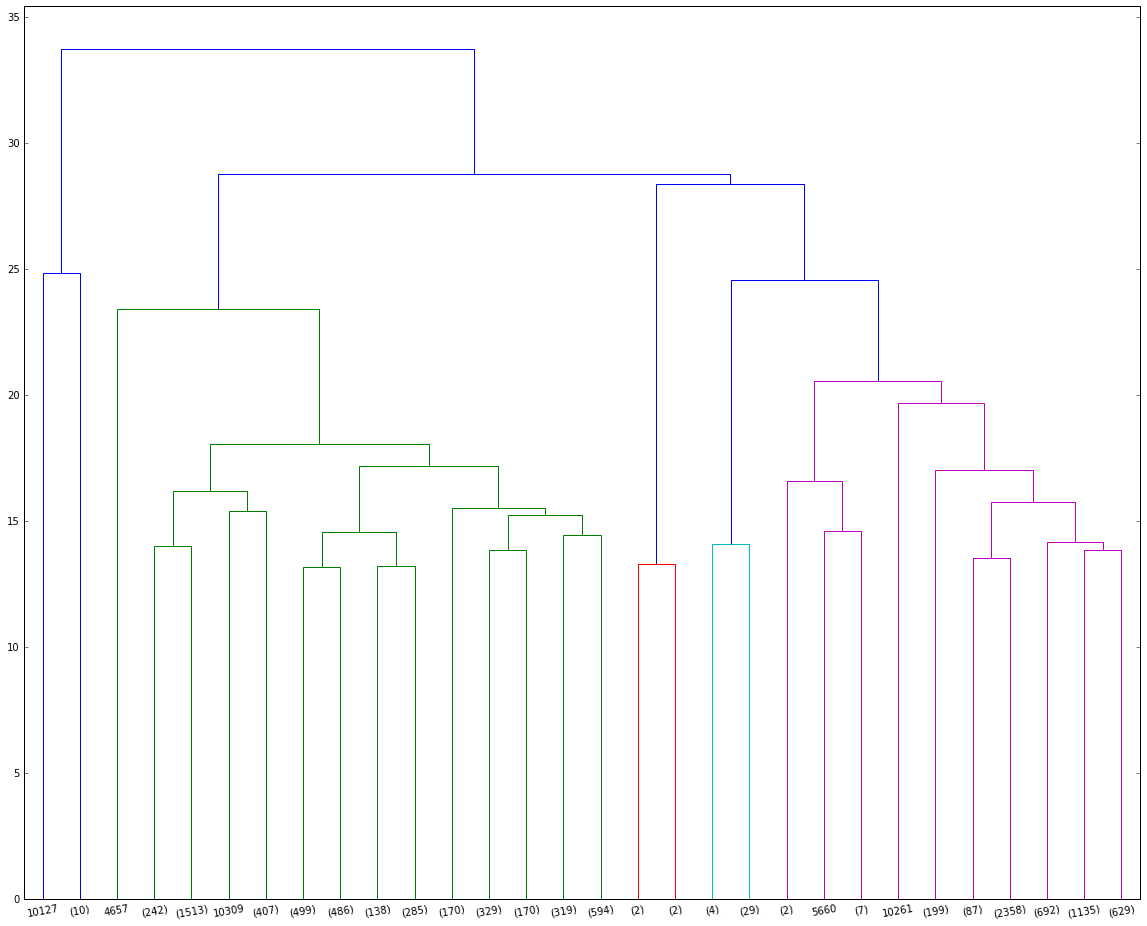

In [71]:
fig = plt.figure(figsize=(20, 16))
tmp=H.dendrogram(Y_d_teta, p=30, truncate_mode='lastp')#, no_plot=True)
# tables = [dteta_in_time, dphi_in_time]
# dist_m = np.array([squareform(pdist(np.array(t), 'euclidean')) for t in tables])
# dist_m_tmp = np.average(dist_m, axis = 0)
print dist_m.shape

In [70]:
P_mv = 15

out = H.fcluster(Y_d_teta, P_mv, 'maxclust')
for i, C in enumerate(Cells):
    C.P=out[i]
    C_next = C.M
    while C_next != VF_R.R:
        C_next.P = out[i]
        C_next = C_next.M

starting_cells = []
        
p_1 = 1
p_2 = 2
p_3 = 0
# starting_cells = starting_cells_to_keep
t=0
min_=600
max_=2200
for t in range(0, 200, 5):
    print t
    to_check = VF_R.time[t][::4]#starting_cells#[C for C in VF_R.time[t][::4] if 2300<C.pos[2]<2600 or C in next_cells]
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    next_cells = []
    for C in to_check:#starting_cells:#VF_R.time[t][::4]:#
        if hasattr(C, 'P'):
            D = np.float(C.P)#spherical_trsf(C.M.pos - mean_center)[2] - spherical_trsf(C.pos - mean_center)[2]
        else:
            D = P_mv+1
        #dist_v(C.M.pos, C.pos)
        actual = C.M
        next_ = C
        i=0
        if C in starting_cells:
            next_cells.append(C.M)
            min_ = min(min_, C.pos[2])
            max_ = max(max_, C.pos[2])
            alpha = 1-(C.pos[p_3]-min_)/(max_-min_)
            col = cm.Accent(min(D/(P_mv+1), 1.))
        else:
            alpha = 1-(C.pos[p_3]-min_)/(max_-min_)
            col = cm.Accent(min(D/(P_mv+1), 1.))#(1.,1.,1., 1.)
        while next_.M != VF_R.R and i<4:
            i+=1
            ax.arrow((actual.pos[p_1]), (actual.pos[p_2]), (next_.pos[p_1]-(actual.pos[p_1])), 
                     ((next_.pos[p_2])-(actual.pos[p_2])), alpha=alpha, color=col)
            actual = next_
            next_ = next_.M
        ax.plot((actual.pos[p_1]), (actual.pos[p_2]), 'o', alpha = alpha, 
                markersize=5, color=col, mec = col)
    #     ax.plot(mean_center[0], mean_center[1], 'ko', markersize=5)
    starting_cells = next_cells
    ax.set_xlim(0, 2000)
#     ax.set_ylim(0, 2000)
    ax.set_ylim(1500, 3500)
    fig.savefig(path_to_files + '\VFYZ_cluster_15\\time%04d.png'%t)
    plt.close()
gc.collect()

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195


49457584

In [36]:
out = H.fcluster(Y_d_teta, P_mv, 'maxclust')
for i, C in enumerate(Cells):
    C.P=out[i]
    C_next = C.M
    while C_next != VF_R.R:
        C_next.P = out[i]
        C_next = C_next.M

print len(Cells), len(out)
print np.unique(out)
print np.unique([C.P for C in Cells if hasattr(C, 'P')])

10313 10313
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [31]:
plt.close("all")

In [32]:
p = index.Property()
p.dimension = 3
idx3d = index.Index(properties=p)
for i, C in LT.time[0].iteritems():
    idx3d.add(i, tuple(C.pos))


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [84]:
number_of_div100 = {}
for C in VF_R.time[0]:
    id_c = list(idx3d.nearest(tuple(C.pos), 1))[0]
    if dist_v(LT.time[0][id_c].pos, C.pos)<100:
        number_of_div100.setdefault(id_c, []).append(C)
nb_div = {C: len(v) for Cs, v in number_of_div100.iteritems() for C in v}

number_of_div50 = {}
for C in VF_R.time[0]:
    id_c = list(idx3d.nearest(tuple(C.pos), 1))[0]
    if dist_v(LT.time[0][id_c].pos, C.pos)<50:
        number_of_div50.setdefault(id_c, []).append(C)
nb_div = {C: len(v) for Cs, v in number_of_div50.iteritems() for C in v}

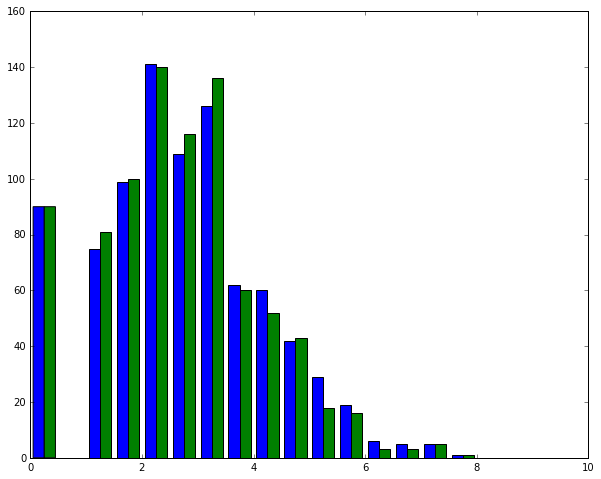

In [85]:
nb_div = {C: len(v) for Cs, v in number_of_div100.iteritems() for C in v}
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

v100 = [np.log2(len(v)) for v in number_of_div100.itervalues()]
v50 = [np.log2(len(v)) for v in number_of_div50.itervalues()]
ax.hist([v100, v50], bins=20, range=(0, 10))

for i, C in enumerate(VF_R.time[0]):
    if nb_div.has_key(C):
        C.P = nb_div.get(C, 1)
        C_next = C.M
        while C_next != VF_R.R:
            C_next.P = nb_div.get(C, 0)
            C_next = C_next.M
    else:
        C.P = None
        C_next = C.M
        while C_next != VF_R.R:
            C_next.P = None
            C_next = C_next.M


In [134]:
p_1 = 1
p_2 = 2
p_3 = 0
# starting_cells = starting_cells_to_keep
t=0
min_=0
max_=2200
P_mv = 8
min_ = 2*np.pi
max_ = 0
import colorsys
for i, C in enumerate(VF_R.time[0]):
    min_ = min(spherical_trsf(C.M.pos - mean_center)[1], min_)
    max_ = max(spherical_trsf(C.M.pos - mean_center)[1], max_)
for i, C in enumerate(VF_R.time[0]):
    pos_c = colorsys.hsv_to_rgb((spherical_trsf(C.M.pos - mean_center)[1]-min_)/(max_-min_), 1., 1.)
    C.pos_c = pos_c
    C_next = C.M
    while C_next != VF_R.R:
        C_next.pos_c = pos_c
        C_next = C_next.M


for t in range(0, 200, 5):
    print t
#     for R in range(500, 2000, 50):
#     to_check = [C for C in VF_R.time[t][::4] if not C.P is None and np.log2(C.P)>4]#VF_R.time[t][::4]
#     to_check += [C for C in LT.time[t].itervalues() if R<C.pos[0]<R+100]
    #[::4]#starting_cells#[C for C in VF_R.time[t][::4] if 2300<C.pos[2]<2600 or C in next_cells]
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    next_cells = []
    for C in VF_R.time[t][::4]:#to_check:#starting_cells:#
        if hasattr(C, 'P') and not C.P is None:
            D = np.log2(C.P)#spherical_trsf(C.M.pos - mean_center)[2] - spherical_trsf(C.pos - mean_center)[2]
        else:
            D = 0#np.log(P_mv+1)
#         D = C.pos_c
        #dist_v(C.M.pos, C.pos)
        actual = C.M
        next_ = C
        i=0
        next_cells.append(C.M)
        min_ = min(min_, C.pos[2])
        max_ = max(max_, C.pos[2])
        alpha = 1-(C.pos[p_3]-min_)/(max_-min_)
        count = 0
        col = cm.plasma(min(D/((P_mv+1)), 1.))
        col = C.pos_c
#         if C in LT.time[t].values():
#             col = (0., 1., 0., 1.)
#         elif C.P is None:
#             col = (1., 0., 0., 1.)
        while next_.M != VF_R.R and i<4:
            i+=1
            ax.arrow((actual.pos[p_1]), (actual.pos[p_2]), (next_.pos[p_1]-(actual.pos[p_1])), 
                     ((next_.pos[p_2])-(actual.pos[p_2])), alpha=alpha, color=col)
            actual = next_
            next_ = next_.M
        ax.plot((actual.pos[p_1]), (actual.pos[p_2]), 'o', alpha = alpha, 
                markersize=5, color=col, mec = col)
    #     ax.plot(mean_center[0], mean_center[1], 'ko', markersize=5)
    starting_cells = next_cells
    ax.set_xlim(0, 2000)
#     ax.set_ylim(0, 2000)
    ax.set_ylim(1500, 3500)
    fig.savefig(path_to_files + '\VFYZ_pos\\time%04d.png'%t)
    plt.close()
    gc.collect()
    
print count

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
0


tmp


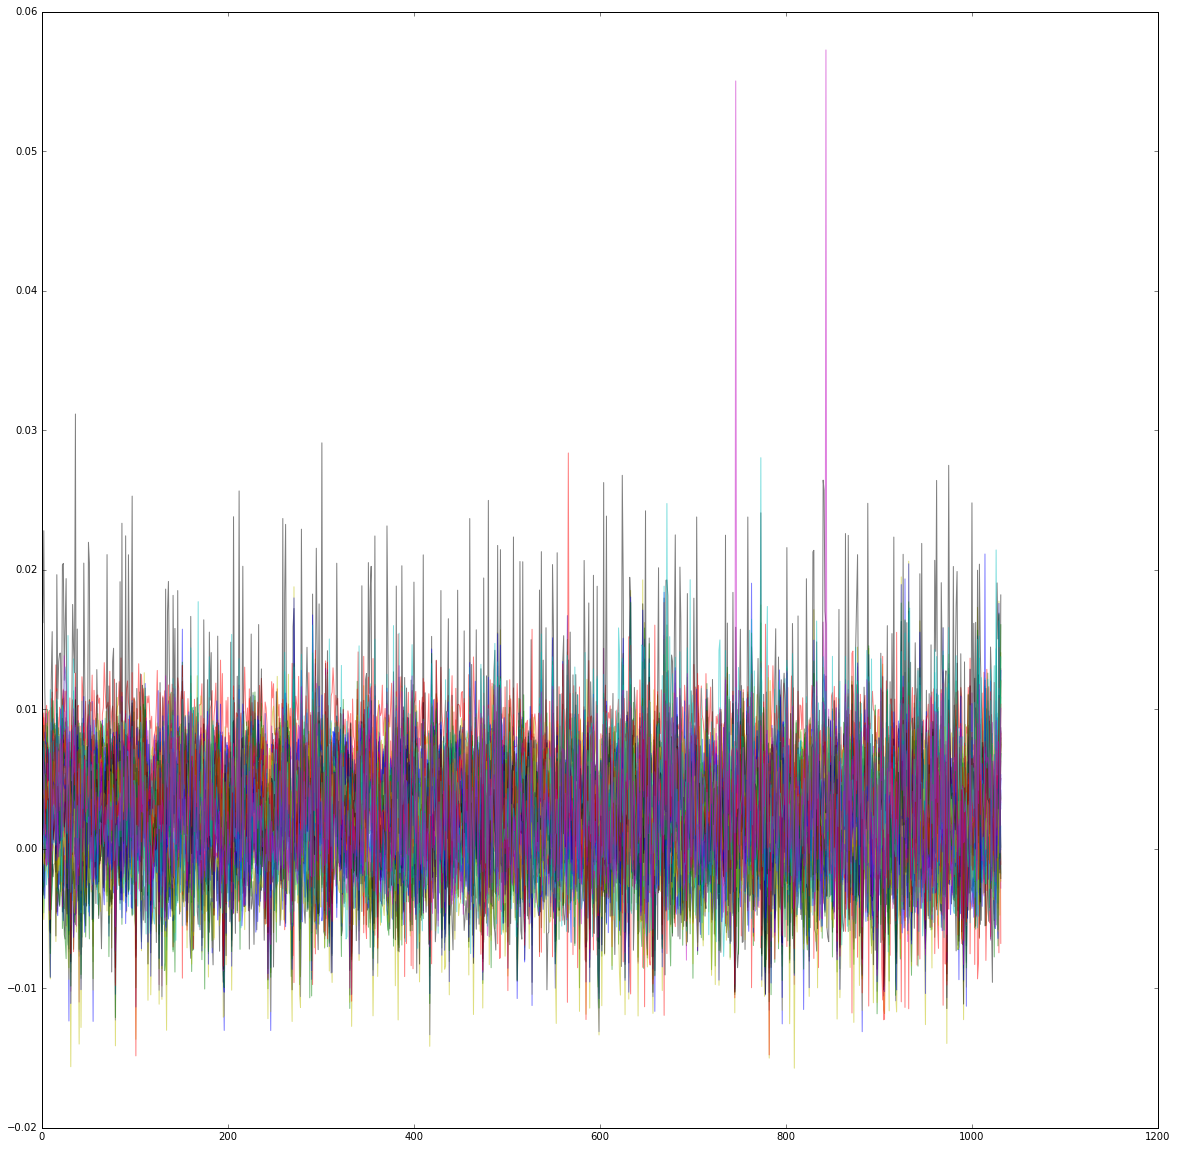

In [138]:
P_mv = 1000
out = H.fcluster(Y_d_teta, P_mv, 'maxclust')
plt.figure(figsize=(20, 20))
# plt.hist(out, range=(0, P_mv), bins=P_mv)
plt.plot(dteta_in_time[::10], alpha=.5)
print 'tmp'